# Validate Data for model deployment


<b>With this tutorial you:</b><br />
Understand how use Eurybia to do data validation in a simple use case<br />

Contents:
- Build a model to deploy
- Do data validation between learning dataset and production dataset
- Generate Report 
- Analysis of results

Data from Kaggle [Titanic](https://www.kaggle.com/c/titanic)<br />

**Requirements notice** : the following tutorial may use third party modules not included in Eurybia.  
You can find them all in one file [on our Github repository](https://github.com/MAIF/eurybia/blob/master/requirements.dev.txt) or you can manually install those you are missing, if any.

In [2]:
import pandas as pd
from category_encoders import OrdinalEncoder
import catboost
from eurybia.core.smartdrift import SmartDrift
from sklearn.model_selection import train_test_split

## Building Supervized Model


In [3]:
from eurybia.data.data_loader import data_loading

In [4]:
titan_df = data_loading('titanic')

In [5]:
features = ['Pclass', 'Age', 'Embarked', 'Sex', 'SibSp', 'Parch', 'Fare']
features_to_encode = ['Pclass', 'Embarked', 'Sex']

In [6]:
encoder = OrdinalEncoder(cols=features_to_encode)
encoder.fit(titan_df[features]) 

is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


OrdinalEncoder(cols=['Pclass', 'Embarked', 'Sex'],
               mapping=[{'col': 'Pclass', 'data_type': dtype('O'),
                         'mapping': Third class     1
First class     2
Second class    3
NaN            -2
dtype: int64},
                        {'col': 'Embarked', 'data_type': dtype('O'),
                         'mapping': Southampton    1
Cherbourg      2
Queenstown     3
NaN           -2
dtype: int64},
                        {'col': 'Sex', 'data_type': dtype('O'),
                         'mapping': male      1
female    2
NaN      -2
dtype: int64}])

In [7]:
titan_df_encoded = encoder.transform(titan_df[features])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    titan_df_encoded,
    titan_df['Survived'].to_frame(),
    test_size=0.2,
    random_state=11
)

In [9]:
i=0
indice_cat  = []
for feature in titan_df_encoded:
    if feature in features_to_encode:
        indice_cat.append(i)
    i=i+1

In [10]:
model = catboost.CatBoostClassifier(loss_function= "Logloss", eval_metric="Logloss",
        learning_rate=0.143852,
        iterations=500,
        l2_leaf_reg=15,
        max_depth = 4)

In [11]:
train_pool_cat = catboost.Pool(data=X_train, label= y_train, cat_features = indice_cat)
test_pool_cat = catboost.Pool(data=X_test, label=y_test, cat_features = indice_cat) 

In [12]:
model.fit(train_pool_cat, eval_set=test_pool_cat, silent=True)
y_pred = model.predict(X_test)

## Creating a fake dataset as a production dataset



In [13]:
import random

In [14]:
df_production = titan_df.copy()

In [15]:
df_production['Age'] = df_production['Age'].apply(lambda x: random.randrange(10, 76)).astype(float)
df_production['Fare'] = df_production['Fare'].apply(lambda x: random.randrange(1, 100)).astype(float)
list_sex= ["male", "female"]
df_production['Sex'] = df_production['Sex'].apply(lambda x: random.choice(list_sex))

In [16]:
df_baseline = titan_df[features]
df_current = df_production[features]

In [17]:
df_current.head()

,Pclass,Age,Embarked,Sex,SibSp,Parch,Fare
PassengerId,,,,,,,
1,Third class,44.0,Southampton,female,1,0,84.0
2,First class,40.0,Cherbourg,female,1,0,6.0
3,Third class,48.0,Southampton,male,0,0,6.0
4,First class,41.0,Southampton,female,1,0,41.0
5,Third class,61.0,Southampton,male,0,0,61.0


In [18]:
df_baseline.head()

,Pclass,Age,Embarked,Sex,SibSp,Parch,Fare
PassengerId,,,,,,,
1,Third class,22.0,Southampton,male,1,0,7.25
2,First class,38.0,Cherbourg,female,1,0,71.28
3,Third class,26.0,Southampton,female,0,0,7.92
4,First class,35.0,Southampton,female,1,0,53.10
5,Third class,35.0,Southampton,male,0,0,8.05


## Use Eurybia for data validation

In [19]:
from eurybia import SmartDrift

In [20]:
SD = SmartDrift(df_current=df_current,
                df_baseline=df_baseline,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [21]:
%time 
SD.compile(full_validation=True # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
            )

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 15.7 µs


In [22]:
SD.generate_report(    
    output_file='report_titanic.html',    
    title_story="Data validation",
    title_description="""Titanic Data validation""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_titanic.yml" # Optional: add information on report     
    )

Report saved to ./report_titanic.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Eurybia is designed to generate an HTML report for analysis, and less for use in notebook mode. 
However, to illustrate functionalities, we will detail results with notebook mode analysis.

## Analysis of results of the data validation

Data validation methodology is based on the ability of a model to discriminate whether an individual belongs to one of the two datasets.
For this purpose a target 0 is assigned to the baseline dataset and a target 1 to the current dataset.
Then a classification model (catboost) is learned to predict this target.
The level of capacity of the data drift classifier to detect if an individual belongs to one of the 2 datasets represents the level of difference between the 2 datasets

### Detection data drift performance

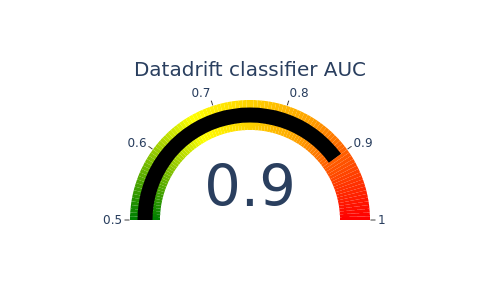

In [23]:
#Performance of data drift classifier
SD.plot.generate_indicator(fig_value=SD.auc, height=300, width=500, title="Datadrift classifier AUC")

such a high auc means that datasets are not similar.The differences should be analysed before deploying model in production

### Importance of features in data drift

This graph represents the variables in the data drift classification model that are most important to differentiate between the two datasets.

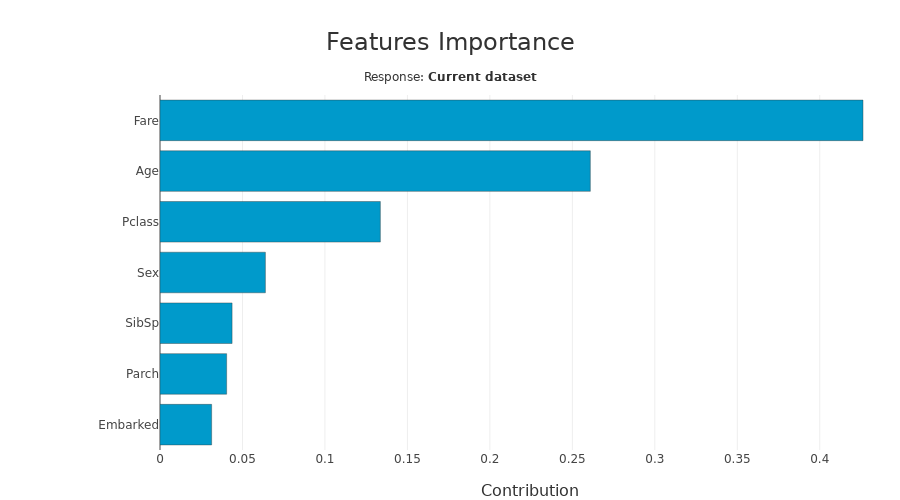

In [24]:
SD.xpl.plot.features_importance()

Features that explain most differences are fare, age and sex. This makes sense because it is features that have been altered


### Feature importance overview

This graph compares the importance of variables between the data drift classifier model and the deployed model. This allows us to put into perspective the importance of data drift in relation to the impacts to be expected on the deployed model. If the variable is at the top left, it means that the variable is very important for data drift classification, but that the variable has little influence on the deployed model. If the variable is at the bottom right, it means that the variable has little importance for data drift classification, and that the variable has a lot of influence on the deployed model.

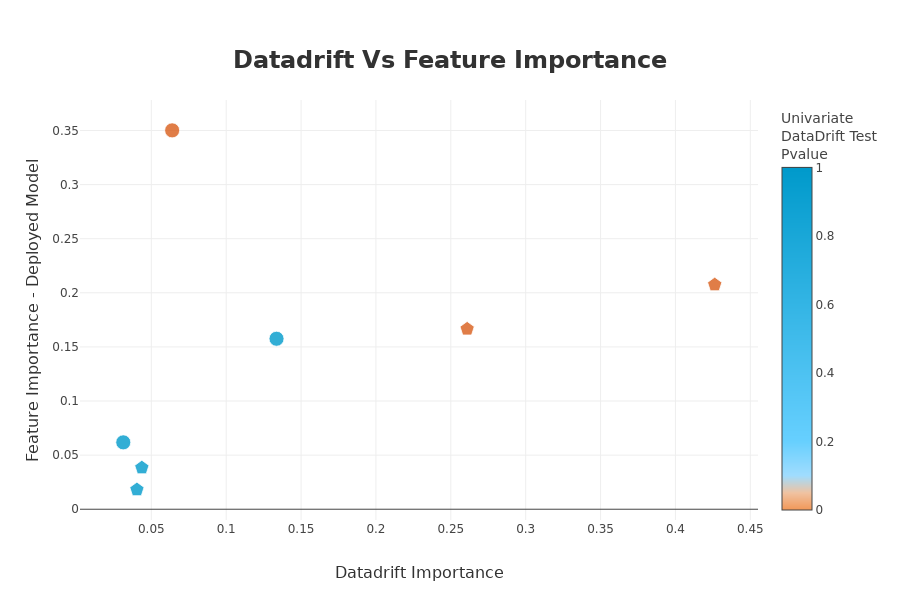

In [25]:
SD.plot.scatter_feature_importance() # works if deployed_model is filled

Features that have the most difference are quite important for the deployed model.

### Univariate analysis

This graphs shows a particular feature's distribution over its possible values. In the drop-down menu, the variables are sorted by importance of the variables in the data drift classification. For categorical features, the possible values are sorted by descending difference between the two datasets.

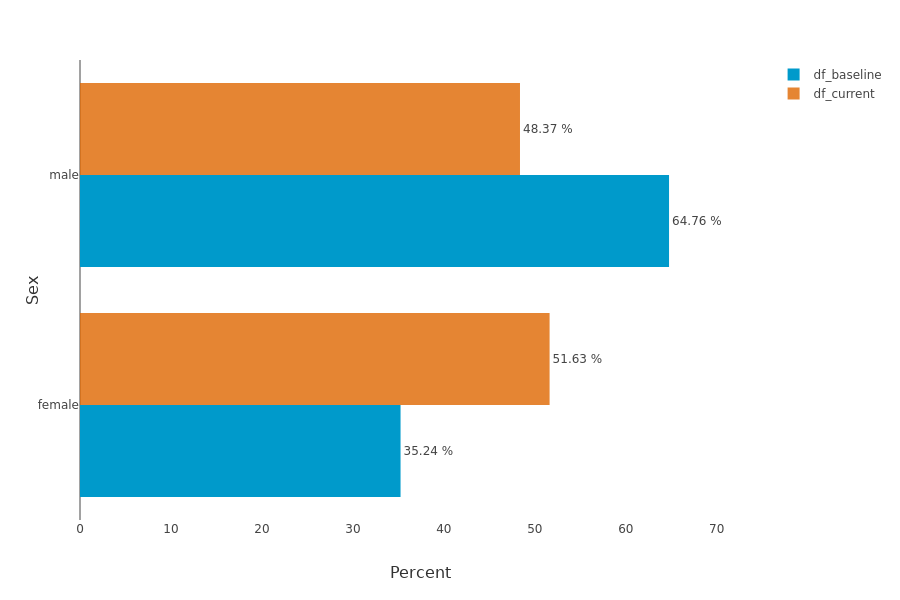

In [26]:
SD.plot.generate_fig_univariate('Sex')

### Distribution of predicted values

This graph shows distributions of the production model outputs on both baseline and current datasets.

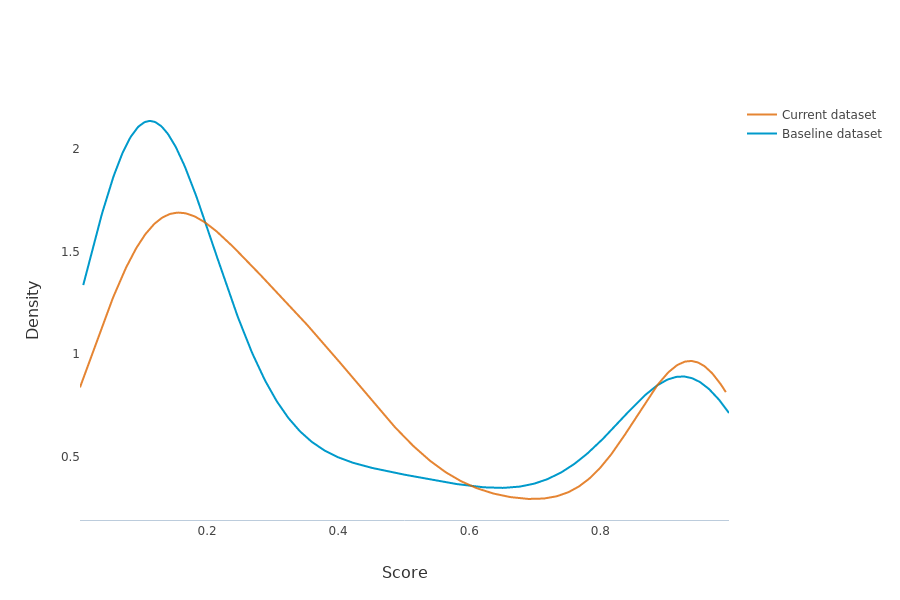

In [27]:
SD.plot.generate_fig_univariate(df_all=SD.df_predict,col='Score',hue="dataset") # works if deployed_model is filled

Differences between 2 datasets generate a difference in the distribution of the predictions of the deployed model. These differences can have important impacts on the performance of the model in production

Jensen Shannon Divergence (JSD). The JSD measures the effect of a data drift on the deployed model performance. A value close to 0 indicates similar data distributions, while a value close to 1 tend to indicate distinct data distributions with a negative effect on the deployed model performance.

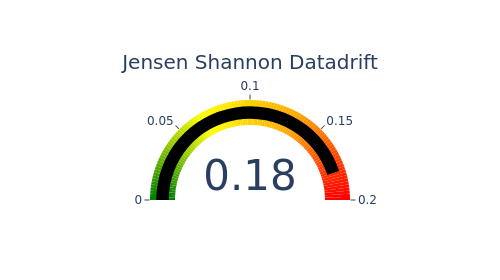

In [28]:
SD.plot.generate_indicator(
                fig_value=SD.js_divergence,
                height=280,
                width=500,
                title="Jensen Shannon Datadrift",
                min_gauge=0,
                max_gauge=0.2,
            ) #works if deployed_model is filled

### Feature contribution on data drift's detection

This graph represents the contribution of a variable to the data drift detection. This graph can help to understand the drift when the analysis of the dataset, either numerical or graphical, does not allow a clear understanding. In the drop-down menu, the variables are sorted by importance of the variables in the data drift detection.

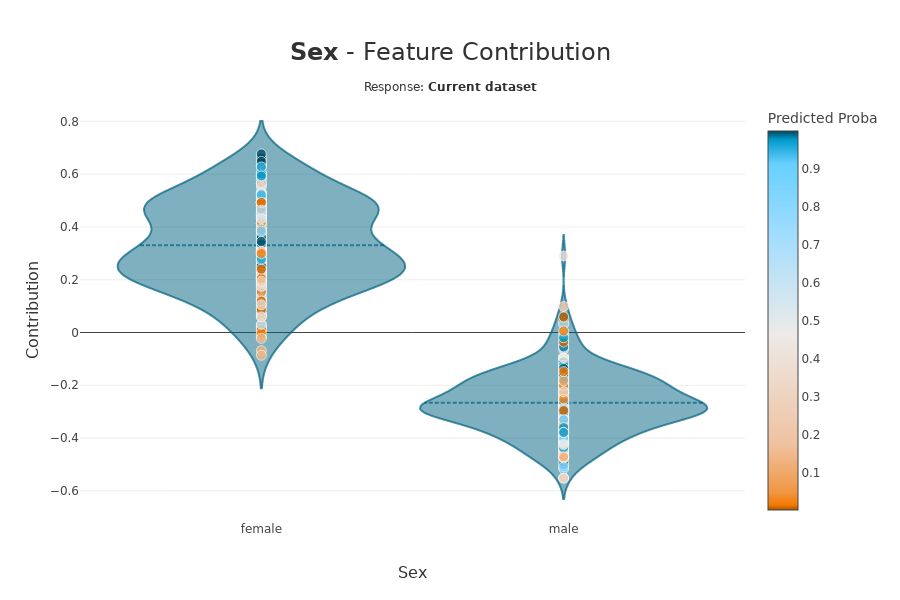

In [29]:
SD.xpl.plot.contribution_plot('Sex')

This graph is more complex and is usefull for few use case. It provides an understanding of interpretation of the datadrift classifier feature by feature